In [1]:
%matplotlib notebook

In [2]:
# import altair as alt
#import csv
# from dateutil.parser import parse
# from dateutil import parser
# import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime
import math

# alt.renderers.enable('default')  # Note: identical to enable('default')


/home/phil/.pyenv/versions/3.6.3/envs/jupyter3/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:

filename = 'project/Good and bad case examples/CHL_WAVE.csv'


In [4]:

# Default method for loading data
# fn: filename
# columns: Dictionary mapping CSV column header : DataFrame column name
# datecols: Dictionary specifying DataFrame columns to be converted to a datetime and corresponding
#   time_delta column (new col_diff)
# returns DataFrame
def load_data(fn, columns=None, datecols=None):
    options = {}
    if type(columns) is dict:
        options = {'usecols': columns.keys()}
    df = pd.read_csv(fn, **options)
    if columns:
        df = df.rename(columns=columns)


    if datecols:
        for k, v in datecols.items():
            df[v] = pd.to_datetime(df[k])
            # Name of a time difference column
            diffcol = v + '_diff'
            df[diffcol] = df[v].diff()
            # By default this converts to nanoseconds. Scale to make this useful.
            df[diffcol] = pd.to_numeric(df[diffcol]) / 1000000000
            if k != v:
                df = df.drop(columns=k)

    return df


In [5]:

resp_data = load_data(
    filename,
    columns={'Time': 'tstext', 'Flow_LPM': 'flow', 'Volume': 'vti', 'Exp_Vol': 'vte'},
    datecols={'tstext': 'ts'}
)


In [6]:
# Details about the dataset
running_time = resp_data['ts'][len(resp_data) - 1] - resp_data['ts'][0]
print('Flow data length', len(resp_data))
print('Running time', running_time, 'or', running_time.total_seconds(), 'seconds' )


Flow data length 30847
Running time 0 days 00:05:08.370000 or 308.37 seconds


<IPython.core.display.Javascript object>


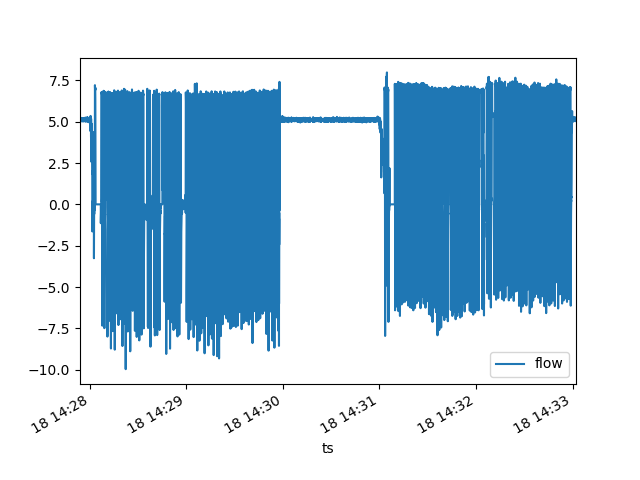

In [7]:
# Plot the flow data 
pd.DataFrame(resp_data).plot(x='ts', y='flow', )

In [8]:
# Prepare some functions that will allow us to count the number of cycles in 
# a repeatable manner

# Simple moving average geneated by a convolution with a defined window size.
# To more realistically represent realtime usage, the convolution only includes
# data up to and including the current step in the timeseries, since in realtime
# we can't see into the future.
# Returns results the same size as the input data
def moving_average(x, w):
    pattern = np.append(np.ones(w), np.zeros(w)) 
#     pattern = np.ones(w)
    return np.convolve(x, pattern, 'same') / w

# Count the number of times we cross the moving average from below to above,
# and measure the time period between each trigger.
# We use smoothed flow data, to avoid small jitters in the data, and make the general
# progression of the flow more clear.
# Aggregate the absolute delta of the smoothed flow for each flow cycle,
# resetting it every time we trigger. This allows for low activity cycles to be rejected.
def rolling_trigger(index, row, df):
    val = row['smooth_flow']
    ma = row['long_ma_positive_flow']
    ts = row['ts']

    if rolling_trigger.prev_val < ma and val >= ma:
        rolling_trigger.count += 1

        if rolling_trigger.prev_ts:
            d_ts = ts - rolling_trigger.prev_ts
            rolling_trigger.cycles.append(d_ts)
            df.at[index, 'cycle_period'] = d_ts
            df.at[index, 'cycle_period_s'] = d_ts.total_seconds()

        rolling_trigger.prev_ts = ts
        rolling_trigger.activity.append(rolling_trigger.prev_activity)
        df.at[index, 'activity'] = rolling_trigger.prev_activity
        rolling_trigger.prev_activity = 0
    else:
        rolling_trigger.prev_activity += abs(val - rolling_trigger.prev_val)

    rolling_trigger.prev_val = val

    return rolling_trigger.count

def reset_rolling_trigger():
    rolling_trigger.count  = 0
    rolling_trigger.prev_val = 0
    rolling_trigger.prev_ts = None
    rolling_trigger.prev_activity = 0
    rolling_trigger.activity = []
    rolling_trigger.cycles = []


resp_data['positive'] = resp_data['flow'].clip(0,100)
resp_data['smooth_flow'] = moving_average(resp_data['flow'], 10)
# Get the moving average for only positive flow, since this will help limit
# the activity to include the start and end of the input flow
# and make a trigger point (a moving average) of the cycle more obvious.
resp_data['long_ma_positive_flow'] = moving_average(resp_data['positive'], 1000)

resp_data['cycle_period'] = None
resp_data['cycle_period_s'] = None
resp_data['activity'] = None

reset_rolling_trigger()
for index, row in resp_data.iterrows():
    rolling_trigger(index, row, resp_data)



<IPython.core.display.Javascript object>


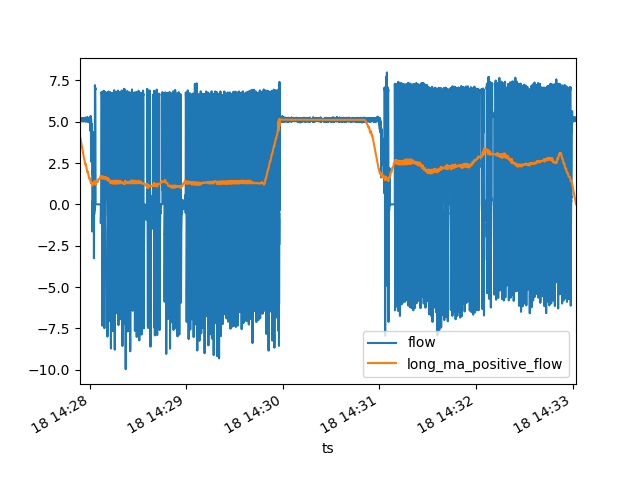

In [9]:
# Long moving average for positive flow, as used for thresholding
resp_data.plot(x='ts', y=['flow', 'long_ma_positive_flow'])

In [10]:
cycles = rolling_trigger.count
print('Total number of trigger points before filtering', cycles)


Total number of trigger points before filtering 524


<IPython.core.display.Javascript object>


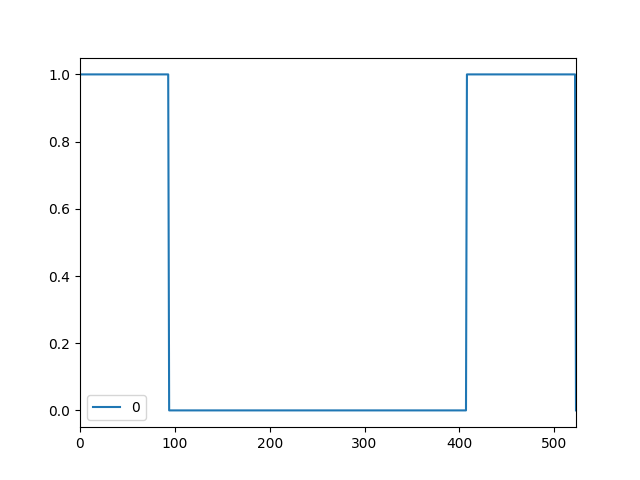

In [11]:
# Smooth the activity, which is the aggregated absolute delta flow for a cycle,
# so we can avoid short bursts of spurious activity from being seen as something
# we need to measure
smooth_activity = np.array( moving_average(rolling_trigger.activity, 10) )

# Flag when there is activity above a threshold with boolean value
activity_threshold = 5
activity_flag = np.rint(np.clip(smooth_activity, 0, activity_threshold) / activity_threshold)

# Plot activity flag to see when activity was happening
pd.DataFrame(activity_flag).plot()

In [12]:
# Get an array of cycles where the activity is above the threshold
unthresholded_cycles = np.array(rolling_trigger.cycles)
# To check how the unthresholded cycle periods appear plot the following
# pd.DataFrame(unthresholded_cycles).plot()

<IPython.core.display.Javascript object>


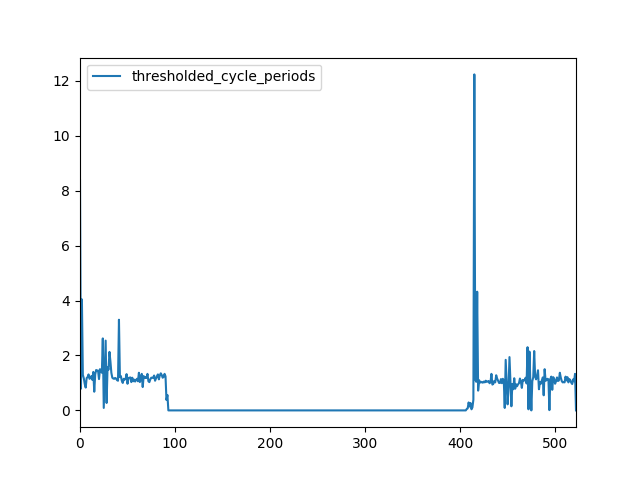

In [13]:
thresholded_cycle_timedeltas = np.multiply(unthresholded_cycles, activity_flag[1: len(unthresholded_cycles)+1])
thresholded_cycle_periods = [max(0, t.total_seconds()) for t in thresholded_cycle_timedeltas]

# Setup thresholded dataframe
df_thresholded_cycle_periods = pd.DataFrame()
df_thresholded_cycle_periods['thresholded_cycle_periods'] = thresholded_cycle_periods
df_thresholded_cycle_periods.plot()

In [14]:
# Remove the cycle periods that are zeros (indicated no activity)
# so we can get a sensible mean / median when there was activity
df_vp_active = df_thresholded_cycle_periods['thresholded_cycle_periods'] > 0.01
active_cycle_periods = df_thresholded_cycle_periods[df_vp_active]

In [15]:
# Simple stats for cycles when activity was actually happening
mean_tp = np.mean(active_cycle_periods)
median_tp = np.median(active_cycle_periods)
print('Mean cycle period', mean_tp)
print('Median cycle period', median_tp)


Mean cycle period thresholded_cycle_periods    1.227816
dtype: float64
Median cycle period 1.125


<IPython.core.display.Javascript object>


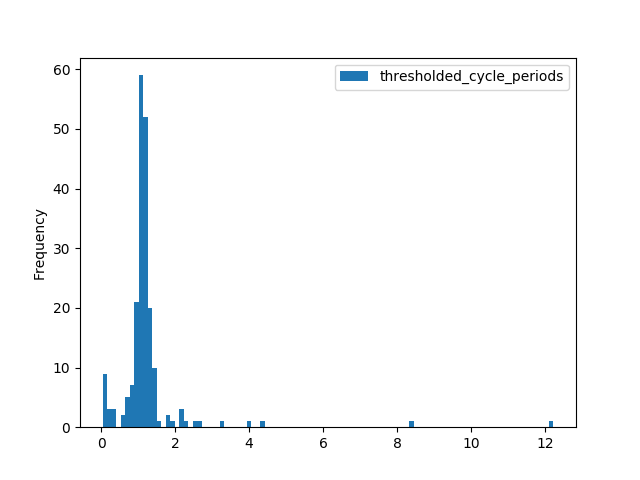

In [16]:
active_cycle_periods.plot.hist('zeroed_cycle_periods', bins=100)

In [ ]:
## Discussion

# We have a model for:
# - calculate a threshold for flow activity based on a moving average 
# - identify when useful activity is happening
# - use the threshold to count trigger points at the start of flow cycles
# - measure the period for each cycle
# - generate some stats that show the range of flow cycle periods
#
# In future we could correlate these flow cycle periods to attributes of the child and link to positive outcomes 
#